### RNN 

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   
import tensorflow as tf
from tensorflow import keras
from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection
)
from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN, LSTM, TimeDistributed, BatchNormalization
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import TimeSeriesSplit
from keras.regularizers import l1, l2
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [31]:
# import the data
netflix = pd.read_csv('netflix_model_ready.csv',
                        parse_dates=True,
                        infer_datetime_format=True,
                        index_col="date"
                        )
                      


In [32]:
netflix = netflix.drop(['target_1', 'target_2', 'target_4', 'target_5'], axis=1)
target_3 = netflix["target_3"]

#splitting into training sets 
column_indices = {name: i for i, name in enumerate(netflix.columns)}

n = len(netflix)
X_train = netflix[0:int(n*0.7)]
X_val = netflix[int(n*0.7):int(n*0.9)]
X_test = netflix[int(n*0.9):]

y_train = target_3[0:int(n*0.7)]
y_val = target_3[int(n*0.7):int(n*0.9)]
y_test = target_3[int(n*0.9):]

In [33]:
Mscaler = MinMaxScaler() # keeps binarys at zero and 1 :)

X_train = pd.DataFrame(Mscaler.fit_transform(X_train), columns = netflix.columns)
X_val = pd.DataFrame(Mscaler.fit_transform(X_val), columns = netflix.columns)
X_test = pd.DataFrame(Mscaler.fit_transform(X_test), columns = netflix.columns)

In [34]:
def df_to_X_y2(df, target, window_size=10):
  df_as_np = df.to_numpy() # converts to matrix of numpy arrays
  X = []
  y = []
  for i in range(len(df_as_np)-window_size): # length of data frame - window_size so it does't take empty values at the end, 
    # does force you to loose the last 5 values, could fix with padding
    row = [r for r in df_as_np[i:i+window_size]] # grabs row i and all rows above within the window size length
    X.append(row) # creates 3 dimentional array, (# obseravtions, # rows in window, # features)
    label = target[i+window_size] # pulls the target variable after the window, target varible needs to be column zero in this 
    y.append(label) # returns (N,) martix of targets i+window_length time periods away
  return np.array(X), np.array(y)

In [78]:
sklearn_pca = PCA(n_components=20)
X_train_1 = pd.DataFrame(sklearn_pca.fit_transform(X_train))
X_val_1 = pd.DataFrame(sklearn_pca.fit_transform(X_val))
X_test_1 = pd.DataFrame(sklearn_pca.fit_transform(X_test))

# converting to window format, in this case 5 periods
X_train_1, train_5w = df_to_X_y2(X_train_1,y_train)
X_val_1, val_5w = df_to_X_y2(X_val_1, y_val)
X_test_1, test_5w = df_to_X_y2(X_test_1,y_test) 


print(X_train_1.shape, train_5w.shape)
print(X_val_1.shape, val_5w.shape)
print(X_test_1.shape, test_5w.shape)

(494, 10, 20) (494,)
(134, 10, 20) (134,)
(63, 10, 20) (63,)


In [79]:
n_steps = X_train_1.shape[1]
n_features = X_train_1.shape[2]

# Let's make a list of CONSTANTS for modelling:
LAYERS = [8, 8, 8, 1]                # number of units in hidden and output layers
M_TRAIN = X_train_1.shape[0]           # number of training examples (2D)
M_TEST = X_test_1.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train_1.shape[2]                 # number of features
BATCH = M_TRAIN                          # batch size
EPOCH = 10                           # number of epochs
LR = 5e-2                            # learning rate of the gradient descent
LAMBD = 3e-2                         # lambda in L2 regularizaion
DP = 0.0                             # dropout rate
RDP = 0.0                            # recurrent dropout rate

# Build the Model
model = Sequential()
model.add(LSTM(input_shape=(n_steps, n_features), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid', 
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))

model.add(BatchNormalization())
model.add(Dense(units=LAYERS[3], activation='sigmoid'))

In [80]:
model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer="adam")
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 10, 8)             928       
                                                                 
 batch_normalization_17 (Bat  (None, 10, 8)            32        
 chNormalization)                                                
                                                                 
 lstm_18 (LSTM)              (None, 10, 8)             544       
                                                                 
 batch_normalization_18 (Bat  (None, 10, 8)            32        
 chNormalization)                                                
                                                                 
 lstm_19 (LSTM)              (None, 8)                 544       
                                                                 
 batch_normalization_19 (Bat  (None, 8)              

In [81]:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation

history = model.fit(X_train_1, train_5w,
                    epochs=100,
                    batch_size=50,
                    validation_data=(X_val_1, val_5w))

Epoch 1/100
10/10 [==============================] - 5s 70ms/step - loss: 3.1107 - accuracy: 0.5101 - val_loss: 2.8014 - val_accuracy: 0.4851
Epoch 2/100
10/10 [==============================] - 0s 21ms/step - loss: 2.8867 - accuracy: 0.5304 - val_loss: 2.6762 - val_accuracy: 0.4478
Epoch 3/100
10/10 [==============================] - 0s 17ms/step - loss: 2.6863 - accuracy: 0.5324 - val_loss: 2.5551 - val_accuracy: 0.4776
Epoch 4/100
10/10 [==============================] - 0s 19ms/step - loss: 2.5511 - accuracy: 0.5385 - val_loss: 2.4386 - val_accuracy: 0.4925
Epoch 5/100
10/10 [==============================] - 0s 19ms/step - loss: 2.4153 - accuracy: 0.5567 - val_loss: 2.3280 - val_accuracy: 0.5149
Epoch 6/100
10/10 [==============================] - 0s 20ms/step - loss: 2.3093 - accuracy: 0.5202 - val_loss: 2.2233 - val_accuracy: 0.5075
Epoch 7/100
10/10 [==============================] - 0s 19ms/step - loss: 2.1890 - accuracy: 0.5547 - val_loss: 2.1246 - val_accuracy: 0.5224
Epoch 

In [82]:
# Evaluate the model:
train_loss, train_acc = model.evaluate(X_train_1, train_5w,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = model.evaluate(X_test_1, test_5w,
                                     batch_size=M_TEST, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

-----------------------------------------------------------------
train accuracy = 75.3036%
test accuracy = 58.7302%
test error = 26 out of 63 examples


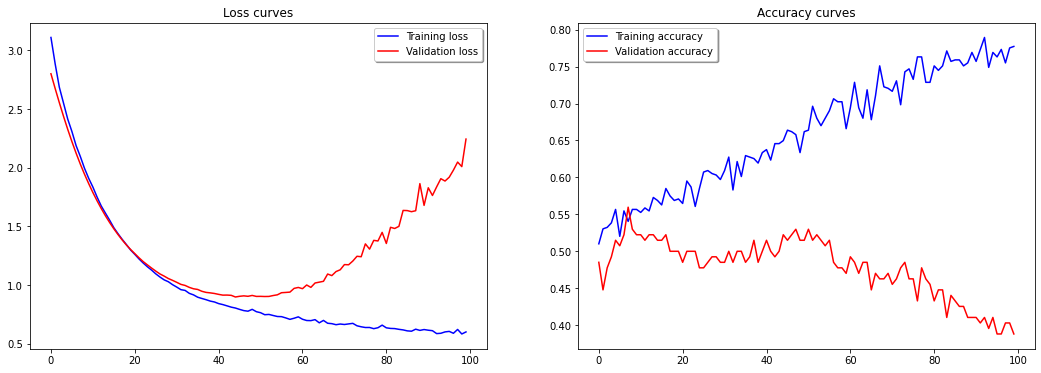

In [83]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(history.history['loss'], color='b', label='Training loss')
axs[0].plot(history.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(history.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(history.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [339]:
y_hat = model.predict(X_test_1, batch_size=50, verbose=1)
#score = sum(y_hat == y_test) / len(y_test)
#print(f'Prediction accuracy = {score*100}%')
index = pd.date_range(start='2017-01-02', end='2018-06-19', freq='B')
for i in range(y_hat.shape[0]):
    print(index[i], y_hat[i], test_5w[i])

2/2 [==============================] - 1s 17ms/step
2017-01-02 00:00:00 [0.02544427] [1]
2017-01-03 00:00:00 [0.03112036] [0]
2017-01-04 00:00:00 [0.02240884] [0]
2017-01-05 00:00:00 [0.0214214] [0]
2017-01-06 00:00:00 [0.02060744] [0]
2017-01-09 00:00:00 [0.03876346] [0]
2017-01-10 00:00:00 [0.06182319] [0]
2017-01-11 00:00:00 [0.07037172] [1]
2017-01-12 00:00:00 [0.09498399] [0]
2017-01-13 00:00:00 [0.16495144] [0]
2017-01-16 00:00:00 [0.23665068] [1]
2017-01-17 00:00:00 [0.39069465] [0]
2017-01-18 00:00:00 [0.43639162] [1]
2017-01-19 00:00:00 [0.34020293] [0]
2017-01-20 00:00:00 [0.424814] [0]
2017-01-23 00:00:00 [0.34071386] [0]
2017-01-24 00:00:00 [0.6368209] [0]
2017-01-25 00:00:00 [0.57310915] [0]
2017-01-26 00:00:00 [0.58939797] [1]
2017-01-27 00:00:00 [0.5445704] [0]
2017-01-30 00:00:00 [0.48154706] [1]
2017-01-31 00:00:00 [0.43834355] [1]
2017-02-01 00:00:00 [0.20859185] [0]
2017-02-02 00:00:00 [0.04272592] [0]
2017-02-03 00:00:00 [0.01790097] [1]
2017-02-06 00:00:00 [0.01017

[Text(0, 0.5, 'True: 0'), Text(0, 1.5, 'True: 1')]

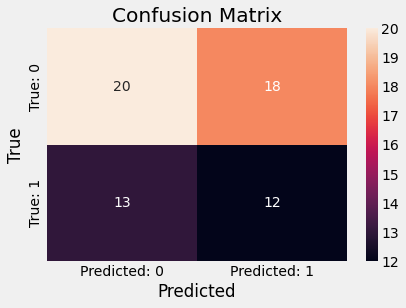

In [340]:
# Display confusion matrix results
from sklearn.metrics import confusion_matrix

ax = plt.subplot()
predicted = model.predict(X_test_1)
predicted = (predicted > 0.5)

confusion = confusion_matrix(test_5w, predicted)

sns.heatmap(confusion, annot=True, ax=ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(["Predicted: 0", "Predicted: 1"])
ax.yaxis.set_ticklabels(["True: 0", "True: 1"])

In [65]:
n_steps = X_train_1.shape[1]
n_features = X_train_1.shape[2]

# Let's make a list of CONSTANTS for modelling:
LAYERS = [32, 32, 32, 1]                # number of units in hidden and output layers
M_TRAIN = X_train_1.shape[0]           # number of training examples (2D)
M_TEST = X_test_1.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train_1.shape[2]                 # number of features
BATCH = M_TRAIN                          # batch size
EPOCH = 10                           # number of epochs
LR = 5e-2                            # learning rate of the gradient descent
LAMBD = 3e-2                         # lambda in L2 regularizaion
DP = 0.0                             # dropout rate
RDP = 0.0                            # recurrent dropout rate

# Build the Model
model2 = Sequential()

model2.add(LSTM(units=LAYERS[2], input_shape=(n_steps, n_features),
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))

model2.add(BatchNormalization())
model2.add(Dense(units=LAYERS[3], activation='sigmoid'))

model2.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer="adam")

print(model2.summary())

history2 = model2.fit(X_train_1, train_5w,
                    epochs=100,
                    batch_size=50,
                    validation_data=(X_val_1, val_5w))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 32)                6784      
                                                                 
 batch_normalization_12 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6,945
Trainable params: 6,881
Non-trainable params: 64
_________________________________________________________________
None
Epoch 1/100
10/10 [==============================] - 2s 37ms/step - loss: 2.6470 - accuracy: 0.5101 - val_loss: 2.4514 - val_accuracy: 0.4104
Epoch 2/100
10/10 [==============================] - 0s 11ms/step - loss: 2.3550 - accuracy: 0.5486 - 

In [55]:
# Evaluate the model:
train_loss, train_acc = model2.evaluate(X_train_1, train_5w,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = model2.evaluate(X_test_1, test_5w,
                                     batch_size=M_TEST, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

-----------------------------------------------------------------
train accuracy = 69.4332%
test accuracy = 55.5556%
test error = 28 out of 63 examples


### Using Correlation for feature selection

In [5]:
netflix = netflix.drop(['target_1', 'target_2', 'target_4', 'target_5'], axis=1)
target_3 = netflix["target_3"]

#splitting into training sets 
column_indices = {name: i for i, name in enumerate(netflix.columns)}

n = len(netflix)
X_train = netflix[0:int(n*0.7)]
X_val = netflix[int(n*0.7):int(n*0.9)]
X_test = netflix[int(n*0.9):]

y_train = target_3[0:int(n*0.7)]
y_val = target_3[int(n*0.7):int(n*0.9)]
y_test = target_3[int(n*0.9):]

In [6]:
Mscaler = MinMaxScaler() 

X_train = pd.DataFrame(Mscaler.fit_transform(X_train), columns = netflix.columns)
X_val = pd.DataFrame(Mscaler.fit_transform(X_val), columns = netflix.columns)
X_test = pd.DataFrame(Mscaler.fit_transform(X_test), columns = netflix.columns)

In [7]:
corr_matrix = X_train.corr()
corr_matrix

,Netflix. Inc,Netflix_x,Netflix Stock,Streaming media,Reed Hastings_x,Open,High,Low,Close,Volume,...,Dow_rs,Dow_RSI,Dow_Move,Dow_MAvg_Move,Dow_MAvg_s_Move,Dow_EMA_Move,Dow_Disparity_Move,Dow_Disparity_s_Move,Dow_RSI_Move,target_3
Netflix. Inc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Netflix_x,NaN,1.000000,0.120515,-0.036498,-0.023639,0.089669,0.093748,0.087067,0.094215,-0.005563,...,-0.010449,0.088147,-0.010146,-0.066488,-0.026574,-0.036132,0.066000,0.017821,0.059777,0.016408
Netflix Stock,NaN,0.120515,1.000000,-0.084799,0.034103,0.042851,0.052182,0.032198,0.046048,0.416329,...,0.095930,0.027666,-0.008608,-0.036181,-0.046956,-0.001093,0.002790,0.002112,0.053164,-0.017190
Streaming media,NaN,-0.036498,-0.084799,1.000000,-0.002752,-0.082838,-0.083416,-0.084120,-0.085460,-0.007602,...,-0.025726,-0.039232,0.004281,-0.017550,-0.003948,-0.014024,0.040795,-0.015858,0.004197,0.057956
Reed Hastings_x,NaN,-0.023639,0.034103,-0.002752,1.000000,0.069944,0.069735,0.066182,0.064949,-0.023895,...,0.066170,-0.005692,-0.075937,0.000363,-0.030094,-0.063439,-0.014711,-0.035616,0.058706,0.027614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Dow_EMA_Move,NaN,-0.036132,-0.001093,-0.014024,-0.063439,0.081622,0.077450,0.089444,0.089186,-0.101980,...,-0.211371,0.146765,0.437229,0.646682,0.584085,1.000000,0.161978,0.098152,-0.118936,-0.039816
Dow_Disparity_Move,NaN,0.066000,0.002790,0.040795,-0.014711,0.019873,0.021517,0.026030,0.034082,-0.013903,...,-0.026077,-0.017773,0.685497,0.077847,0.351402,0.161978,1.000000,0.678417,-0.257943,-0.102270
Dow_Disparity_s_Move,NaN,0.017821,0.002112,-0.015858,-0.035616,0.011081,0.015342,0.016836,0.028956,0.010360,...,-0.012761,-0.029004,0.639602,0.063734,0.281990,0.098152,0.678417,1.000000,-0.246003,-0.114530
Dow_RSI_Move,NaN,0.059777,0.053164,0.004197,0.058706,-0.007837,-0.004546,-0.007609,-0.004940,-0.012339,...,0.042549,0.266520,-0.292898,-0.141531,-0.184222,-0.118936,-0.257943,-0.246003,1.000000,-0.004096


In [84]:
#Top 40 variables by correlation with the target, not including target 3 which would have correlation = 1

feats_corr = list(pd.DataFrame(corr_matrix['target_3'].sort_values(ascending=False).iloc[1:41]).reset_index()['index'])

In [85]:
feats_corr

['Stock_rs',
 'Nas_RSI_Move',
 'Google_avg_loss',
 'Nas_rs',
 'Streaming media',
 'dow_vol',
 'Wiki_gain',
 'Wiki_Disparity',
 'Google_Rocp',
 'Stock_Rocp',
 'Wiki_Moment_2_s',
 'Wiki_diff',
 'Dow_Rocp',
 'Wiki_Moment_1_s',
 'Wiki_ROC_s',
 'Wiki_avg_gain',
 'Google_gain',
 'Reed Hastings_x',
 'Dow_MAvg_Move',
 'Google_MAvg_s',
 'Google_Disparity',
 'Google_MAvg_s_Move',
 'Google_Moment_2',
 'nas_vol',
 'Google_total',
 'Netflix_y',
 'Netflix_x',
 'Google_RSI_Move',
 'Google_Move',
 'Wiki_Disparity_s',
 'Wiki_total',
 'Google_Disparity_Move',
 'Nas_Move',
 'Google_ROC_s',
 'Google_Moment_1_s',
 'Wiki_loss',
 'Nas_Disparity_s_Move',
 'Google_ROC',
 'Google_Moment_1',
 'Wiki_MAvg_s']

In [86]:
X_train_cr = X_train[feats_corr]
X_val_cr = X_val[feats_corr]
X_test_cr = X_test[feats_corr]

In [87]:
sklearn_pca = PCA(n_components=20)
X_train_cr = pd.DataFrame(sklearn_pca.fit_transform(X_train_cr))
X_val_cr = pd.DataFrame(sklearn_pca.fit_transform(X_val_cr))
X_test_cr = pd.DataFrame(sklearn_pca.fit_transform(X_test_cr))

In [88]:
# converting to window format, in this case 10 periods
X_train_cr, train_5w = df_to_X_y2(X_train_cr,y_train)
X_val_cr, val_5w = df_to_X_y2(X_val_cr, y_val)
X_test_cr, test_5w = df_to_X_y2(X_test_cr,y_test) 


print(X_train_cr.shape, train_5w.shape)
print(X_val_cr.shape, val_5w.shape)
print(X_test_cr.shape, test_5w.shape)

(494, 10, 20) (494,)
(134, 10, 20) (134,)
(63, 10, 20) (63,)


In [89]:
n_steps = X_train_cr.shape[1]
n_features = X_train_cr.shape[2]

# Let's make a list of CONSTANTS for modelling:
LAYERS = [8, 8, 8, 1]                # number of units in hidden and output layers
M_TRAIN = X_train_cr.shape[0]           # number of training examples (2D)
M_TEST = X_test_cr.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train_1.shape[2]                 # number of features
BATCH = M_TRAIN                          # batch size
EPOCH = 10                           # number of epochs
LR = 5e-2                            # learning rate of the gradient descent
LAMBD = 3e-2                         # lambda in L2 regularizaion
DP = 0.0                             # dropout rate
RDP = 0.0                            # recurrent dropout rate

# Build the Model
model3 = Sequential()
model3.add(LSTM(input_shape=(n_steps, n_features), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model3.add(BatchNormalization())
model3.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid', 
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model3.add(BatchNormalization())
model3.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))

model3.add(BatchNormalization())
model3.add(Dense(units=LAYERS[3], activation='sigmoid'))

In [90]:
model3.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer="adam")
print(model3.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 10, 8)             928       
                                                                 
 batch_normalization_20 (Bat  (None, 10, 8)            32        
 chNormalization)                                                
                                                                 
 lstm_21 (LSTM)              (None, 10, 8)             544       
                                                                 
 batch_normalization_21 (Bat  (None, 10, 8)            32        
 chNormalization)                                                
                                                                 
 lstm_22 (LSTM)              (None, 8)                 544       
                                                                 
 batch_normalization_22 (Bat  (None, 8)              

In [92]:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation

history3 = model3.fit(X_train_cr, train_5w,
                    epochs=100,
                    batch_size=50,
                    validation_data=(X_val_cr, val_5w))

Epoch 1/100
10/10 [==============================] - 0s 22ms/step - loss: 0.6621 - accuracy: 0.6923 - val_loss: 0.8330 - val_accuracy: 0.5746
Epoch 2/100
10/10 [==============================] - 0s 19ms/step - loss: 0.6568 - accuracy: 0.7004 - val_loss: 0.8117 - val_accuracy: 0.6045
Epoch 3/100
10/10 [==============================] - 0s 27ms/step - loss: 0.6617 - accuracy: 0.6943 - val_loss: 0.8373 - val_accuracy: 0.6194
Epoch 4/100
10/10 [==============================] - 0s 21ms/step - loss: 0.6411 - accuracy: 0.7227 - val_loss: 0.8144 - val_accuracy: 0.5821
Epoch 5/100
10/10 [==============================] - 0s 22ms/step - loss: 0.6680 - accuracy: 0.7004 - val_loss: 0.8427 - val_accuracy: 0.5746
Epoch 6/100
10/10 [==============================] - 0s 22ms/step - loss: 0.6624 - accuracy: 0.6964 - val_loss: 0.8073 - val_accuracy: 0.5970
Epoch 7/100
10/10 [==============================] - 0s 20ms/step - loss: 0.6493 - accuracy: 0.7247 - val_loss: 0.8204 - val_accuracy: 0.5672
Epoch 

In [93]:
# Evaluate the model:
train_loss, train_acc = model3.evaluate(X_train_cr, train_5w,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = model3.evaluate(X_test_cr, test_5w,
                                     batch_size=M_TEST, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

-----------------------------------------------------------------
train accuracy = 77.3279%
test accuracy = 44.4444%
test error = 35 out of 63 examples


In [94]:
n_steps = X_train_cr.shape[1]
n_features = X_train_cr.shape[2]

# Let's make a list of CONSTANTS for modelling:
LAYERS = [32, 32, 32, 1]                # number of units in hidden and output layers
M_TRAIN = X_train_cr.shape[0]           # number of training examples (2D)
M_TEST = X_test_cr.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train_cr.shape[2]                 # number of features
BATCH = M_TRAIN                          # batch size
EPOCH = 10                           # number of epochs
LR = 5e-2                            # learning rate of the gradient descent
LAMBD = 3e-2                         # lambda in L2 regularizaion
DP = 0.0                             # dropout rate
RDP = 0.0                            # recurrent dropout rate

# Build the Model
model4 = Sequential()

model4.add(LSTM(units=LAYERS[2], input_shape=(n_steps, n_features),
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))

model4.add(BatchNormalization())
model4.add(Dense(units=LAYERS[3], activation='sigmoid'))

model4.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer="adam")
print(model4.summary())

history4 = model4.fit(X_train_cr, train_5w,
                    epochs=100,
                    batch_size=50,
                    validation_data=(X_val_cr, val_5w))

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 32)                6784      
                                                                 
 batch_normalization_23 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 6,945
Trainable params: 6,881
Non-trainable params: 64
_________________________________________________________________
None
Epoch 1/100
10/10 [==============================] - 2s 34ms/step - loss: 2.7168 - accuracy: 0.5162 - val_loss: 2.4431 - val_accuracy: 0.5000
Epoch 2/100
10/10 [==============================] - 0s 10ms/step - loss: 2.3686 - accuracy: 0.5324 -

In [95]:
# Evaluate the model:
train_loss, train_acc = model4.evaluate(X_train_cr, train_5w,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = model4.evaluate(X_test_cr, test_5w,
                                     batch_size=M_TEST, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

-----------------------------------------------------------------
train accuracy = 62.5506%
test accuracy = 55.5556%
test error = 28 out of 63 examples


### Table Of results 